In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

## Load data

In [4]:
directory = "Testing_data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

Loaded file: acp_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: dnp_d.csv
Loaded file: kgh_d.csv
Loaded file: pkn_d.csv


In [5]:
def get_moving_average(data, period):
    data['MA'] = data['Close'].rolling(period).mean()
    return data

In [6]:
def get_RSI (data, period):
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

In [7]:
def get_ROC(data):
    data['ROC'] = data['Close'].pct_change()
    return data

In [8]:
def get_stochastic_oscillator(data, period):
    L14, H14 = data['Close'].rolling(period).min(), data['Close'].rolling(period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)
    return data

In [9]:
def get_SO_moving_average(data, period):
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    K = (data['Close'] - L14)/(H14 - L14)
    data['D'] = data['K'].rolling(so_d_period).mean()
    return data

In [10]:
def get_MACD(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    data['MACD'] = EMA_short - EMA_long
    return data

In [11]:
# TODO: add functions for MACD related indicators

In [12]:
def get_TEMA(data, period):
    SEMA = data['Close'].ewm(period).mean()
    DEMA = SEMA.ewm(period).mean()
    data['TEMA'] = DEMA.ewm(period).mean()
    return(data)

In [13]:
def get_CGI(data, period):
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)
    return(data)

In [14]:
def get_Williams_Percent_Range(data, period):
    data['Percent_Range'] = (data['Highest'].rolling(period).max() - data['Close']) / (data['Highest'].rolling(period).max() - data['Lowest'].rolling(period).min())
    return(data)

In [15]:
def scale_data(data):
    list_of_features = []
    for column in data.columns:
        list_of_features.append(data[column])

    dataset = np.transpose(list_of_features)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    return scaled_data, scaler

In [16]:
def scale_data_X_Y(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [17]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

# Testing for the best technical indicators parameters

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Checking how algorithm works without techincal indicators (learning based on prices and volume)

In [21]:
X_all = []
Y_all = []
stocks_base = []
results_base = []
# prepare data
for stock in stock_data_list:
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks_base.append(scaled_stock)
# split for training and validation
for stock in stocks_base:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_base.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})

(27145, 60, 5)
(3017, 60, 5)
(27145, 5)
(3017, 5)
Epoch 1/7
849/849 [==============================] - 5s 4ms/step - loss: 0.0043 - val_loss: 5.2311e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.4668e-04 - val_loss: 4.8358e-04
Epoch 3/7
849/849 [==============================] - 3s 4ms/step - loss: 5.1581e-04 - val_loss: 4.9438e-04
Epoch 4/7
849/849 [==============================] - 3s 4ms/step - loss: 5.1325e-04 - val_loss: 4.5828e-04
Epoch 5/7
849/849 [==============================] - 4s 4ms/step - loss: 4.4098e-04 - val_loss: 4.6512e-04
Epoch 6/7
849/849 [==============================] - 3s 4ms/step - loss: 4.4208e-04 - val_loss: 4.3105e-04
Epoch 7/7
849/849 [==============================] - 3s 4ms/step - loss: 4.2671e-04 - val_loss: 4.4242e-04
Epoch 1/7
849/849 [==============================] - 5s 5ms/step - loss: 0.0079 - val_loss: 5.9348e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.4511e-04 - val_loss: 4.9859

In [31]:
results_base = pd.DataFrame(results_base)
results_base

,loss,val_loss
0,0.000448,0.000491


### Moving average

In [32]:
periods = [3, 5, 10, 15, 20, 30, 45, 60, 80, 100, 125, 150, 200]
X_all_MA = []
Y_all_MA = []
results_MA = []


for period in periods:
    X_all_MA = []
    Y_all_MA = []
    stocks_MA = []
    # prepare data
    for stock in stock_data_list:
        stock_MA = get_moving_average(stock, period)
        stock_MA = stock_MA.dropna()
        scaled_stock, stock_scaler = scale_data(stock_MA.drop(columns='Date'))
        stocks_MA.append(scaled_stock)
    # split for training and validation
    for stock_MA in stocks_MA:
        X, Y = prepare_input_and_output(np.array(stock_MA))
        X_all_MA = X_all_MA + X
        Y_all_MA = Y_all_MA + Y
    X_all_MA, Y_all_MA = np.array(X_all_MA), np.array(Y_all_MA)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all_MA, Y_all_MA, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})



(27133, 60, 6)
(3015, 60, 6)
(27133, 5)
(3015, 5)
Period: 3
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0127 - val_loss: 6.6545e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 6.0863e-04 - val_loss: 6.4626e-04
Epoch 3/7
848/848 [==============================] - 4s 4ms/step - loss: 5.2141e-04 - val_loss: 5.6100e-04
Epoch 4/7
848/848 [==============================] - 3s 4ms/step - loss: 4.7182e-04 - val_loss: 5.5378e-04
Epoch 5/7
848/848 [==============================] - 3s 4ms/step - loss: 4.7638e-04 - val_loss: 5.5446e-04
Epoch 6/7
848/848 [==============================] - 3s 4ms/step - loss: 4.3572e-04 - val_loss: 5.1889e-04
Epoch 7/7
848/848 [==============================] - 3s 4ms/step - loss: 4.2584e-04 - val_loss: 5.0851e-04
Epoch 1/7
848/848 [==============================] - 5s 5ms/step - loss: 0.0146 - val_loss: 6.7108e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 6.0635e-04 - val_lo

846/846 [==============================] - 3s 4ms/step - loss: 4.7963e-04 - val_loss: 4.9753e-04
Epoch 6/7
846/846 [==============================] - 4s 4ms/step - loss: 4.9030e-04 - val_loss: 4.7379e-04
Epoch 7/7
846/846 [==============================] - 4s 4ms/step - loss: 4.6225e-04 - val_loss: 4.7371e-04
Epoch 1/7
846/846 [==============================] - 5s 5ms/step - loss: 0.0146 - val_loss: 5.6670e-04
Epoch 2/7
846/846 [==============================] - 4s 4ms/step - loss: 5.8295e-04 - val_loss: 5.7083e-04
Epoch 3/7
846/846 [==============================] - 4s 4ms/step - loss: 5.3479e-04 - val_loss: 5.0887e-04
Epoch 4/7
846/846 [==============================] - 3s 4ms/step - loss: 4.6906e-04 - val_loss: 4.9155e-04
Epoch 5/7
846/846 [==============================] - 3s 4ms/step - loss: 5.0552e-04 - val_loss: 4.7921e-04
Epoch 6/7
846/846 [==============================] - 3s 4ms/step - loss: 4.5999e-04 - val_loss: 5.3213e-04
Epoch 7/7
846/846 [==============================] 

Epoch 3/7
837/837 [==============================] - 3s 4ms/step - loss: 5.1800e-04 - val_loss: 5.2511e-04
Epoch 4/7
837/837 [==============================] - 3s 4ms/step - loss: 4.8192e-04 - val_loss: 4.8577e-04
Epoch 5/7
837/837 [==============================] - 3s 4ms/step - loss: 4.4156e-04 - val_loss: 4.7926e-04
Epoch 6/7
837/837 [==============================] - 3s 4ms/step - loss: 4.4536e-04 - val_loss: 4.8924e-04
Epoch 7/7
837/837 [==============================] - 3s 4ms/step - loss: 4.9098e-04 - val_loss: 4.5671e-04
Epoch 1/7
837/837 [==============================] - 5s 5ms/step - loss: 0.0114 - val_loss: 6.0847e-04
Epoch 2/7
837/837 [==============================] - 3s 4ms/step - loss: 6.3544e-04 - val_loss: 5.3209e-04
Epoch 3/7
837/837 [==============================] - 3s 4ms/step - loss: 5.4738e-04 - val_loss: 5.2066e-04
Epoch 4/7
837/837 [==============================] - 4s 4ms/step - loss: 4.6335e-04 - val_loss: 4.9544e-04
Epoch 5/7
837/837 [======================

824/824 [==============================] - 5s 5ms/step - loss: 0.0097 - val_loss: 6.8394e-04
Epoch 2/7
824/824 [==============================] - 3s 4ms/step - loss: 6.1282e-04 - val_loss: 6.2911e-04
Epoch 3/7
824/824 [==============================] - 3s 4ms/step - loss: 5.7370e-04 - val_loss: 5.8759e-04
Epoch 4/7
824/824 [==============================] - 3s 4ms/step - loss: 5.4854e-04 - val_loss: 5.8391e-04
Epoch 5/7
824/824 [==============================] - 3s 4ms/step - loss: 4.9715e-04 - val_loss: 5.7298e-04
Epoch 6/7
824/824 [==============================] - 3s 4ms/step - loss: 5.0968e-04 - val_loss: 5.3984e-04
Epoch 7/7
824/824 [==============================] - 3s 4ms/step - loss: 4.5170e-04 - val_loss: 5.7297e-04
(26207, 60, 6)
(2912, 60, 6)
(26207, 5)
(2912, 5)
Period: 150
Epoch 1/7
819/819 [==============================] - 5s 4ms/step - loss: 0.0157 - val_loss: 5.4395e-04
Epoch 2/7
819/819 [==============================] - 3s 4ms/step - loss: 6.2544e-04 - val_loss: 4.75

In [33]:
results_MA = pd.DataFrame(results_MA)
results_MA

,period,loss,val_loss
0,3,0.000459,0.000520
1,5,0.000475,0.000404
2,10,0.000481,0.000409
3,15,0.000467,0.000475
4,20,0.000478,0.000431
5,30,0.000484,0.000397
6,45,0.000460,0.000518
7,60,0.000471,0.000463
8,80,0.000473,0.000493
9,100,0.000483,0.000360


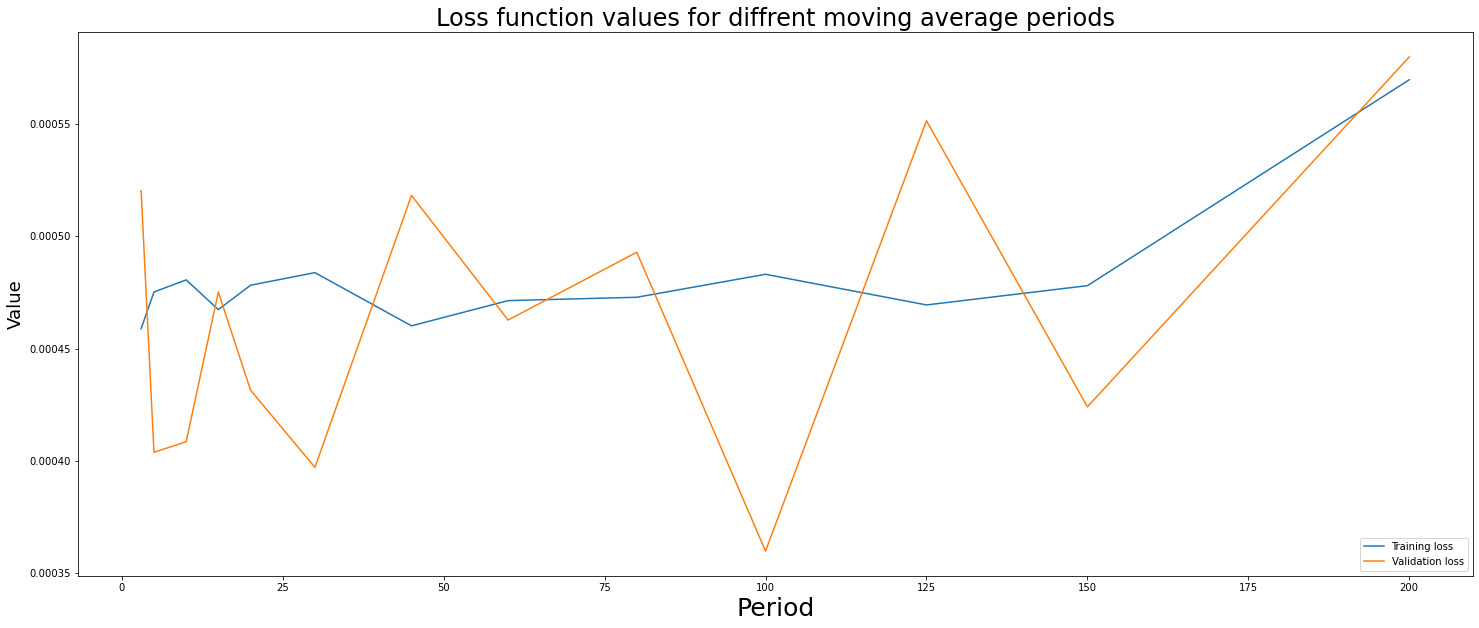

In [34]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MA['period'], results_MA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

### RSI

In [36]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_RSI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_RSI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_RSI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})



(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/10
810/810 [==============================] - 5s 4ms/step - loss: 0.0078 - val_loss: 6.1467e-04
Epoch 2/10
810/810 [==============================] - 3s 4ms/step - loss: 6.0454e-04 - val_loss: 5.6006e-04
Epoch 3/10
810/810 [==============================] - 3s 4ms/step - loss: 6.1696e-04 - val_loss: 5.5690e-04
Epoch 4/10
810/810 [==============================] - 3s 4ms/step - loss: 5.8018e-04 - val_loss: 6.4013e-04
Epoch 5/10
810/810 [==============================] - 3s 4ms/step - loss: 5.7963e-04 - val_loss: 5.0955e-04
Epoch 6/10
810/810 [==============================] - 4s 4ms/step - loss: 5.4902e-04 - val_loss: 5.3892e-04
Epoch 7/10
810/810 [==============================] - 3s 4ms/step - loss: 5.3367e-04 - val_loss: 5.3762e-04
Epoch 8/10
810/810 [==============================] - 3s 4ms/step - loss: 5.3515e-04 - val_loss: 5.1719e-04
Epoch 9/10
810/810 [==============================] - 3s 4ms/step - loss: 5.2232

810/810 [==============================] - 3s 4ms/step - loss: 5.7976e-04 - val_loss: 5.5584e-04
Epoch 7/10
810/810 [==============================] - 3s 4ms/step - loss: 5.5703e-04 - val_loss: 5.8122e-04
Epoch 8/10
810/810 [==============================] - 3s 4ms/step - loss: 5.2951e-04 - val_loss: 5.4641e-04
Epoch 9/10
810/810 [==============================] - 3s 4ms/step - loss: 5.3600e-04 - val_loss: 7.2313e-04
Epoch 10/10
810/810 [==============================] - 3s 4ms/step - loss: 5.4722e-04 - val_loss: 5.4876e-04
Epoch 1/10
810/810 [==============================] - 5s 4ms/step - loss: 0.0420 - val_loss: 0.0011
Epoch 2/10
810/810 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 6.3405e-04
Epoch 3/10
810/810 [==============================] - 3s 4ms/step - loss: 5.7108e-04 - val_loss: 6.6442e-04
Epoch 4/10
810/810 [==============================] - 3s 4ms/step - loss: 5.8315e-04 - val_loss: 6.3469e-04
Epoch 5/10
810/810 [==============================

In [37]:
results_RSI = pd.DataFrame(results_RSI)
results_RSI

,period,loss,val_loss
0,3,0.000548,0.000529
1,5,0.000706,0.000948
2,7,0.000542,0.000550
3,10,0.000542,0.000568
4,14,0.000543,0.000575


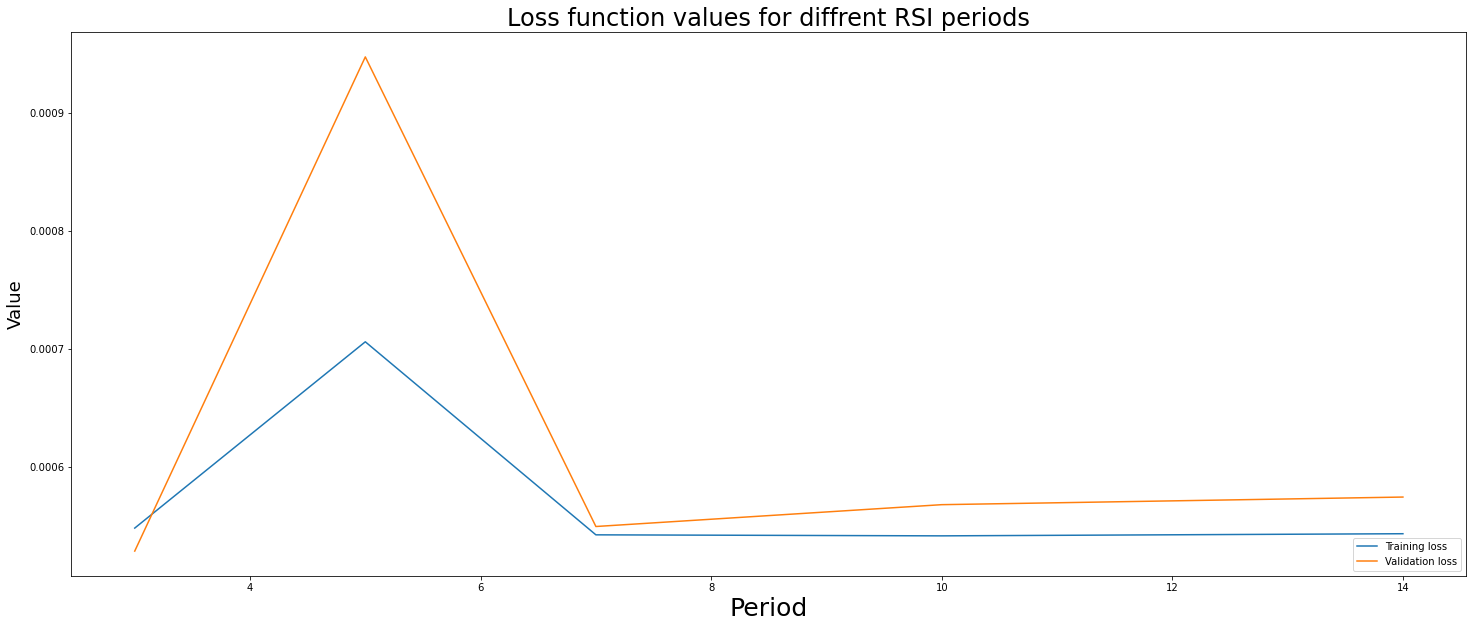

In [38]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent RSI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_RSI['period'], results_RSI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

## ROC

In [40]:
X_all = []
Y_all = []
results_ROC = []


X_all = []
Y_all = []
stocks = []
# prepare data
for stock in stock_data_list:
    stock = get_ROC(stock)
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks.append(scaled_stock)
# split for training and validation
for stock in stocks:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_ROC.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})


(25892, 60, 8)
(2877, 60, 8)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0165 - val_loss: 6.3800e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2742e-04 - val_loss: 6.1654e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9101e-04 - val_loss: 5.7764e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8977e-04 - val_loss: 5.6264e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6888e-04 - val_loss: 5.9096e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9217e-04 - val_loss: 5.4978e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.1045e-04 - val_loss: 5.4322e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0102 - val_loss: 7.5443e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.7244e-04 - val_lo

In [41]:
results_ROC = pd.DataFrame(results_ROC)
results_ROC

,period,loss,val_loss
0,3,0.000553,0.000568


## Stochastic oscillator

In [43]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_SO = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_stochastic_oscillator(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_SO.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})



(25738, 60, 9)
(2860, 60, 9)
(25738, 5)
(2860, 5)
Period: 3
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0073 - val_loss: 6.8851e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 5.7887e-04 - val_loss: 7.4531e-04
Epoch 3/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9115e-04 - val_loss: 6.2297e-04
Epoch 4/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9922e-04 - val_loss: 6.2852e-04
Epoch 5/7
805/805 [==============================] - 3s 4ms/step - loss: 5.4459e-04 - val_loss: 5.9811e-04
Epoch 6/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9341e-04 - val_loss: 6.0717e-04
Epoch 7/7
805/805 [==============================] - 3s 4ms/step - loss: 5.4412e-04 - val_loss: 5.8630e-04
Epoch 1/7
805/805 [==============================] - 5s 5ms/step - loss: 0.0059 - val_loss: 7.4379e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.1279e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0047e-04 - val_loss: 5.7616e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3507e-04 - val_loss: 5.7051e-04
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0085 - val_loss: 6.6444e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5418e-04 - val_loss: 6.0670e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0442e-04 - val_loss: 5.9768e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4137e-04 - val_loss: 5.5880e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4496e-04 - val_loss: 6.0809e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9309e-04 - val_loss: 5.6924e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7562e-04 - val_loss: 5.5953e-04
(25892, 60, 9)
(2877, 60, 9)
(25892, 5)
(

In [44]:
results_SO = pd.DataFrame(results_SO)
results_SO

,period,loss,val_loss
0,3,0.000553,0.000632
1,5,0.000562,0.000554
2,7,0.000559,0.000628
3,10,0.000555,0.000561
4,14,0.000561,0.000569


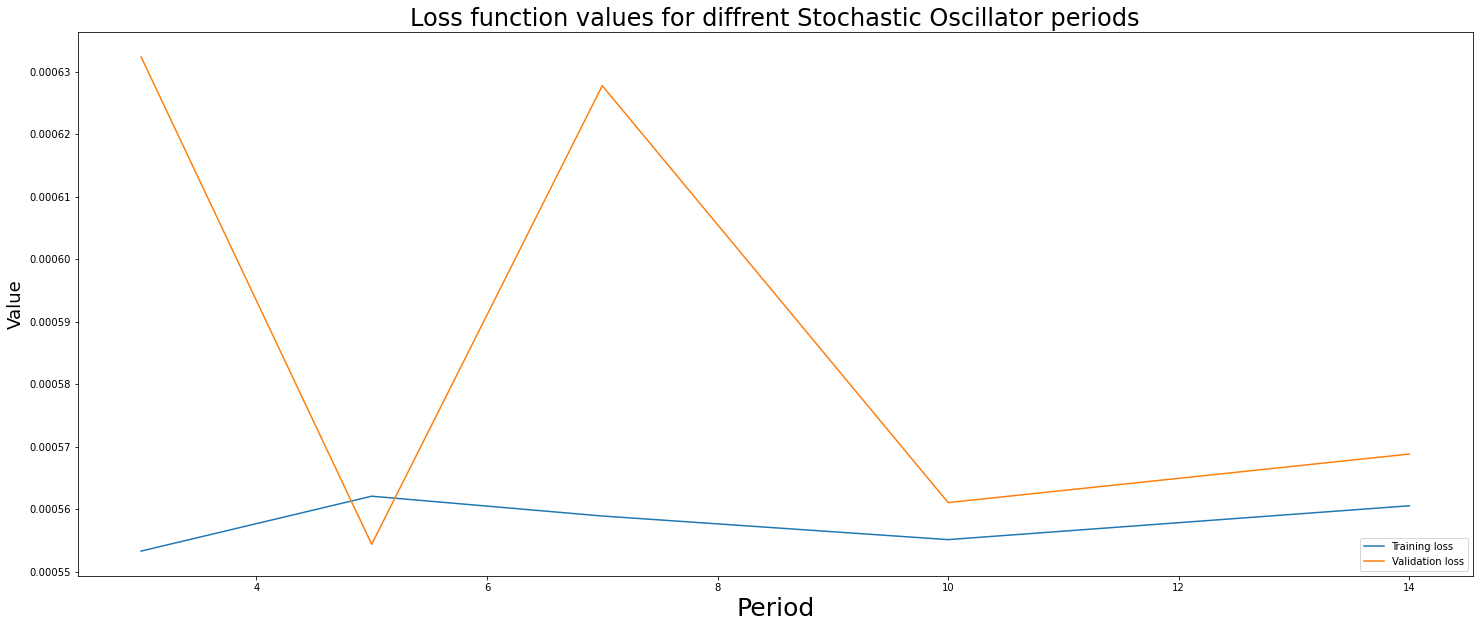

In [45]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent Stochastic Oscillator periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_SO['period'], results_SO[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()